In [55]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob
import os, sys


def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

from matplotlib.text import TextPath

yr_s = 3.154E7



#sys.stdout = TracePrints()

In [353]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
    
    
def extract_nested_dict(d, key_list):
    
    if isinstance(key_list, str):
        return d[key_list]
    elif len(key_list) == 1:
        return d[key_list[0]]
    
    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, self_contained = False,
                 name = None, data_file_name = "*_galaxy_data.h5"):
        
        self.directory = directory
        
        self.self_contained = self_contained # sets if the "file list" is a list
                                             # files to be loaded (False) or 
                                             # a list of data dump names (True)
                                             # contained within the data_file_name
        
        self.file_list      = file_list
        self.data_file_name = data_file_name

        self._data = {} # stores data
        
        if (self.file_list is None):
            
            if not self.self_contained:
                self.file_list = np.sort(glob.glob(directory + '/' + self.data_file_name))
            else:
                raise NotImplementedError 
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        self.load_phase_plots()        
        
        
        if name is None:
            self.name = directory
        else:
            self.name = name
            
        self.load_loading_table()
            
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.t_sf_start = self.data('time')[0]
        self.first_DD   = int(self.t_sf_start)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
    
    
    def load_loading_table(self):
        # load (if available) loading table from LiBryan2019 
        
        loading_table = glob.glob( self.directory + '/*loading_table.dat')
        
        if len(loading_table) == 0:
            self.loading_table_values = None
            print("Loading data table not found for ", self.name)
            return
        
        
        keys = ["Eta_mass", "Eta_mass_hot", "Eta_mass_cold", 
                "Eta_metal", "Eta_metal_hot", "Eta_metal_cold", 
                "Eta_E", "Eta_E_hot", "Eta_E_cold", "Eta_E_hot_cold_ratio",
                "e_s", "e_s_hot", "e_s_cold", "e_s_hot_cold_ratio",
                "Sigma_gas", "Sigma_sfr", "Eta_hot_Eta_Metal_hot_ratio"]
        
        self.loading_table_values = {}
        for k in keys:
            self.loading_table_values[k] = -999
            
        with open(loading_table[0]) as fp:
            count = 0
            for line in fp:
                self.loading_table_values[ keys[count] ] = float(line.split(" ")[-1])
                count = count + 1
    
        return
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                # may need to do this for backwards compatibility. Some versions
                # have all ('gas','cell_mass') esque fields converted to strings
                # otherers still have it as a tuple. Handle tuples here:
                
                try:
                    last_val  = path.split('/')[-1]
                    str0      = last_val.split(',')[0].strip("'").strip("('")   # get first
                    str1      = last_val.split(',')[1].strip(" '").strip("')")  # get second
                
                    temp_data = dd.io.load(filename, path.strip(last_val))
                    self._data[label][i] = temp_data[(str0,str1)]
                    
                except:
                
                    fail_count += 1
                          
            if fail_count > 10:
                print(self.name)
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def load_image(self, time, field, axis, image_type = 'proj'):
        """
        Load (but don't persist) projection data at a given time relative
        to first star formation (already goes and grabs correct corresponding
        data dump). Throws an error if data dump does not exist. Assumes
        projection data is in an HDF5 file that has axis on top level and fields one below
        
        image_type = 'proj' or 'slice'
        """
        #
        # 
        #
        
        dd_num = int(time + self.t_sf_start)
        
        if dd_num < 0:
            print("trying to load a data set before first star formation. Is this really what you want?")
            raise RuntimeError
        
        dsname = "DD%0004i"%(dd_num)
        
        image_str = ''
        if image_type == 'proj':
            image_str = 'Proj'
        else:
            image_str = 'Slice'
            
        if not os.path.isfile(self.directory + '/' + image_type + '/' + dsname + "_" + image_str + "_data.h5"):
            # try +/- one Myr just in case
            if os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num-1) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num-1) 
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num+1) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num+1)
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num+2) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num+2)
            elif os.path.isfile(self.directory + '/' + image_type + '/' + "DD%0004i"%(dd_num-2) + "_" + image_str + "_data.h5"):
                dsname =  "DD%0004i"%(dd_num-2)
            else:
                print("Cannot find ds " +dsname+ " or one +/- 1 away", dd_num, self.name)
                
                return None
                

            
        image_data = dd.io.load(self.directory + '/' + image_type + '/' +\
                                dsname + '_' + image_str + '_data.h5', '/' + axis + '/' + field)
                
        
        
        return image_data
    
    def load_phase_plots(self):
        
        if not os.path.isfile(self.directory + "/nT_disk.png_2D_hist.dat"):
            self._data['nT_phase_disk'] = None
          
        else:        
            self._data['nT_phase_disk'] = {'1D' : {}, '2D' : {}}
            self._data['nT_phase_outside_disk']  = {'1D' : {}, '2D' : {}}
        
            temp = np.loadtxt(self.directory + "/nT_disk.png_bins_1D_hist.dat")
            self._data['nT_phase_disk']['1D']['nbins'] = temp[0]
            self._data['nT_phase_disk']['1D']['nhist'] = temp[1]
            self._data['nT_phase_disk']['1D']['Tbins'] = temp[2]
            self._data['nT_phase_disk']['1D']['Thist'] = temp[3]
        
            self._data['nT_phase_disk']['2D']['hist'] = np.loadtxt(self.directory + '/nT_disk.png_2D_hist.dat')
        
            xbins, ybins = np.zeros(np.size(temp[0]) + 1), np.zeros(np.size(temp[0]) + 1)
            xbins[:-1] = self._data['nT_phase_disk']['1D']['nbins']
            xbins[-1]  = 10.0**(np.log10(xbins[-2]) + (np.log10(xbins[1]) - np.log10(xbins[0])))
            ybins[:-1] = self._data['nT_phase_disk']['1D']['Tbins']
            ybins[-1]  = 10.0**(np.log10(ybins[-2]) + (np.log10(ybins[1]) - np.log10(ybins[0])))
            xmesh, ymesh = np.meshgrid(xbins,ybins)
            self._data['nT_phase_disk']['2D']['nmesh'] = xmesh
            self._data['nT_phase_disk']['2D']['Tmesh'] = ymesh
        
        if not os.path.isfile(self.directory + "/nT_outside_disk.png_2D_hist.dat"):
            self._data['nT_phase_outside_disk'] = None
        else:
            temp = np.loadtxt(self.directory + "/nT_outside_disk.png_bins_1D_hist.dat")
            self._data['nT_phase_outside_disk']['1D']['nbins'] = temp[0]
            self._data['nT_phase_outside_disk']['1D']['nhist'] = temp[1]
            self._data['nT_phase_outside_disk']['1D']['Tbins'] = temp[2]
            self._data['nT_phase_outside_disk']['1D']['Thist'] = temp[3]       
        
            self._data['nT_phase_outside_disk']['2D']['hist'] = np.loadtxt(self.directory + '/nT_outside_disk.png_2D_hist.dat')
       
            xbins, ybins = np.zeros(np.size(temp[0]) + 1), np.zeros(np.size(temp[0]) + 1)
            xbins[:-1] = self._data['nT_phase_outside_disk']['1D']['nbins']
            xbins[-1]  = 10.0**(np.log10(xbins[-2]) + (np.log10(xbins[1]) - np.log10(xbins[0])))
            ybins[:-1] = self._data['nT_phase_outside_disk']['1D']['Tbins']
            ybins[-1]  = 10.0**(np.log10(ybins[-2]) + (np.log10(ybins[1]) - np.log10(ybins[0])))
            xmesh, ymesh = np.meshgrid(xbins,ybins)
            self._data['nT_phase_outside_disk']['2D']['nmesh'] = xmesh
            self._data['nT_phase_outside_disk']['2D']['Tmesh'] = ymesh
        
           
        return
    
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [354]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : fid_dir + '/../3pc_H2', 'fiducial-1.8pc' : fid_dir}
             

labels    = {'sn_only' : 'SN-only',
             'ion_no-otrad-sn' : 'Ionization only',
             'otrad_ion-no-sn' : 'Radiation only',
             'otrad_no-ion-sn' : 'PE+LW only',
             'shortrad'        : 'shortrad',
             'shortrad_72pc'   : 'shortrad-72pc',
             'sn_ion-no-otrad' : 'SN + Ion',
             'sn_otrad_no-ion' : 'SN + PE+LW',
             'snlw'            : 'SN + LW',
             'snpe'            : 'SN + PE',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'     : 'RPx0',
             'fiducial-1.8pc' : 'Fiducial-1.8pc',
             'fiducial'      : 'Fiducial'}

markers =    {'sn_only' : 'X',
             'ion_no-otrad-sn' : 'D',
             'otrad_ion-no-sn' : 'D',
             'otrad_no-ion-sn' : 'D',
             'shortrad'        : '*',
             'shortrad_72pc'   : '*',
             'sn_ion-no-otrad' : '*',
             'sn_otrad_no-ion' : '*',
             'snlw'            : '*',
             'snpe'            : '*',
             'sn_otrad_ion_RPx2' : '*',
             'sn_otrad_ion_RPx5' : '*',
             'sn_otrad_ion_noRP'     : '*',
             'fiducial-1.8pc' : 'P',
             'fiducial'      : 'P'}

#markers = {}
#for k in labels.keys():
#    markers[k] = TextPath((0,0), labels[k])


base_comparison = ['fiducial', 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only', 
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP', 'shortrad']

sn_runs = ['fiducial','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']
no_sn_runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']
misc_runs  = ['sn_otrad_ion_noRP','shortrad']

colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
#
#colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


if True:
    # try some color scheme
    colors['fiducial'] = 'black';        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] = 'C1'; lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] = 'C1'; lstyles['sn_otrad_no-ion'] = '--'
    colors['snlw']            = 'C4'; lstyles['snlw']            = '--'
    colors['snpe']            = 'C6'; lstyles['snpe']            = ':'
    colors['sn_only']  = 'C1';        lstyles['sn_only'] = ':'
    
    colors['otrad_ion-no-sn'] = 'C3';  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = 'C3';  lstyles['otrad_no-ion-sn'] = '--'
    colors['ion_no-otrad-sn'] = 'C3';  lstyles['ion_no-otrad-sn'] = ':' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C2'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C2'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C2'; lstyles['sn_otrad_ion_RPx5'] = ':'

else:
    colors['fiducial']        =  magma(0.8);        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] =  magma(0.6); lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] =  magma(0.4); lstyles['sn_otrad_no-ion'] = '-'
    colors['sn_only']         =  magma(0.2);        lstyles['sn_only'] = '-'
    
    colors['otrad_ion-no-sn'] = viridis(0.8);  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = viridis(0.6);  lstyles['otrad_no-ion-sn'] = '-'
    colors['ion_no-otrad-sn'] = viridis(0.4);  lstyles['ion_no-otrad-sn'] = '-' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C1'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C1'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C1'; lstyles['sn_otrad_ion_RPx5'] = ':'


for l in labels:
    if not (l in filepaths.keys()):
        filepaths[l] = work_dir + '/' + l
        
#
#
# plot limits for consistency
#
#
global_time_lim = [0.0, 750.0]

In [355]:
all_data = {}

runs_to_load = labels.keys()

#runs_to_load = ['fiducial']
for k in runs_to_load:
    print(k)
    all_data[k] = DataContainer( filepaths[k], name = k)



sn_only
ion_no-otrad-sn
otrad_ion-no-sn
otrad_no-ion-sn
shortrad
shortrad_72pc
sn_ion-no-otrad
sn_otrad_no-ion
snlw
snpe
sn_otrad_ion_RPx2
sn_otrad_ion_RPx5
sn_otrad_ion_noRP
fiducial-1.8pc
Loading data table not found for  fiducial-1.8pc
fiducial


In [361]:
for run in labels.keys():
    t = all_data[run].load_field('time')
    print("%30s      %5.2f Myr"%(run, t[-1]-t[0]))

                       sn_only      137.00 Myr
               ion_no-otrad-sn      920.00 Myr
               otrad_ion-no-sn      857.00 Myr
               otrad_no-ion-sn      521.00 Myr
                      shortrad      390.00 Myr
                 shortrad_72pc      256.00 Myr
               sn_ion-no-otrad      767.00 Myr
               sn_otrad_no-ion      681.00 Myr
                          snlw      92.00 Myr
                          snpe      234.00 Myr
             sn_otrad_ion_RPx2      757.00 Myr
             sn_otrad_ion_RPx5      892.00 Myr
             sn_otrad_ion_noRP      739.00 Myr
                fiducial-1.8pc      899.00 Myr
                      fiducial      999.00 Myr


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


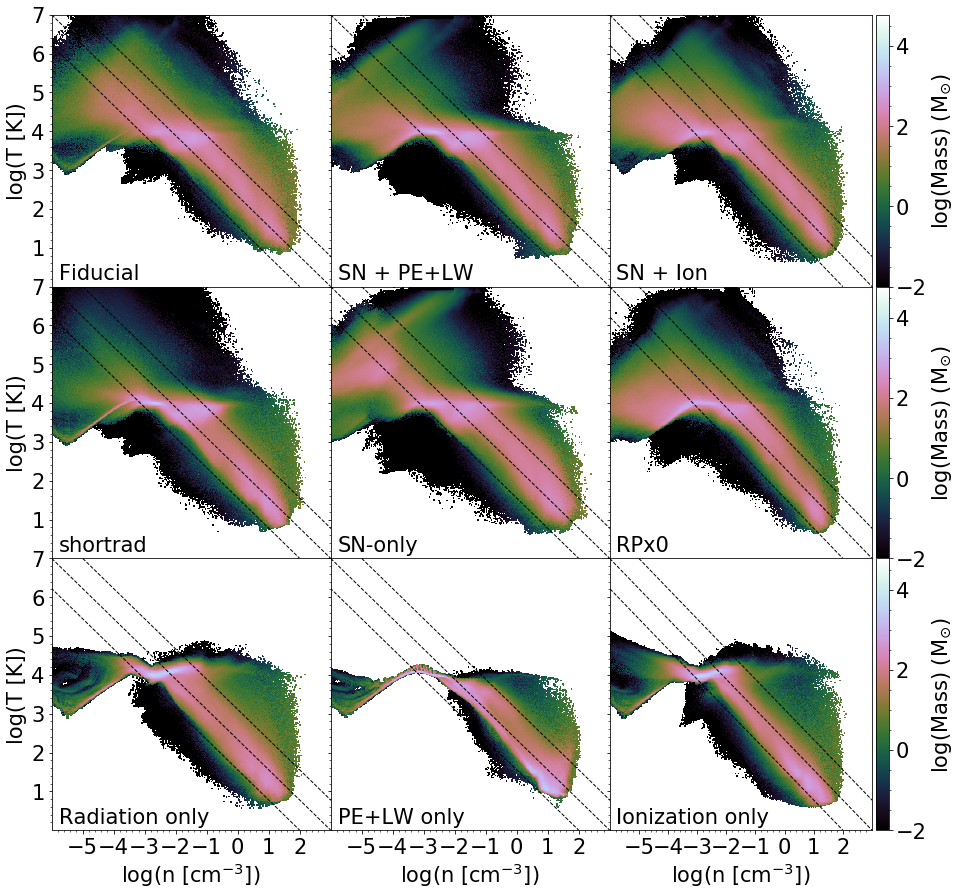

In [47]:
plot_settings()

fs = 5

fig, ax = plt.subplots(3,3, sharex=True, sharey=True)
fig.set_size_inches(fs*3,fs*3)
fig.subplots_adjust(wspace=0,hspace=0)

#
# plot many panel phase diagram
#


runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']

phase_type = 'nT_phase_disk'
#phase_type = "nT_phase_outside_disk"

axi,axj=0,0
for i,run in enumerate(runs):
    axindex = (axi,axj)
    
    
    if axi == 2:
        ax[axindex].set_xlabel(r"log(n [cm$^{-3}$])")
        ax[axindex].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    if axj == 0:
        ax[axindex].set_ylabel(r"log(T [K])")
        ax[axindex].set_yticks([1,2,3,4,5,6,7])
            

    # iterate for now to work woth continue
    axj = axj + 1
    if axj >= 3:
        axj = 0
        axi = axi + 1
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    xmesh = phase_data['2D']['nmesh']
    ymesh = phase_data['2D']['Tmesh']
    zmesh = phase_data['2D']['hist']
    im = ax[axindex].pcolormesh( np.log10(xmesh), np.log10(ymesh), np.log10(zmesh.T), cmap = 'cubehelix',
                            #norm = LogNorm(),
                                 vmin=np.log10(0.01), vmax = np.log10(6.0E4))
    
    #ax[axindex].annotate(xy,xytext=)
    #ax[axindex].semilogx()
    #ax[axindex].semilogy()
    ax[axindex].set_xlim(-6,3)
    ax[axindex].set_ylim(0,7)
    
    ax[axindex].plot( [-6,3], [7,0], lw = 1, ls = '--', color = 'black')
    ax[axindex].plot( [-5,4], [7,0], lw = 1, ls = '--', color = 'black')
    ax[axindex].plot( [-7,2], [7,0], lw = 1, ls = '--', color = 'black')


    if axindex[1] == 2:
        divider = make_axes_locatable(ax[axindex])
        cax     = divider.append_axes("right", size="5%", pad=0.05)    
    
        
        c = fig.colorbar(im, cax=cax)
        c.set_label(r"log(Mass) (M$_{\odot}$)")
        
    
    xy = (0.025,0.025)
    ax[axindex].annotate( labels[run], xy=xy,xycoords='axes fraction')

    plt.minorticks_on()

fig.savefig("phase_plot_" + phase_type + ".png")
        

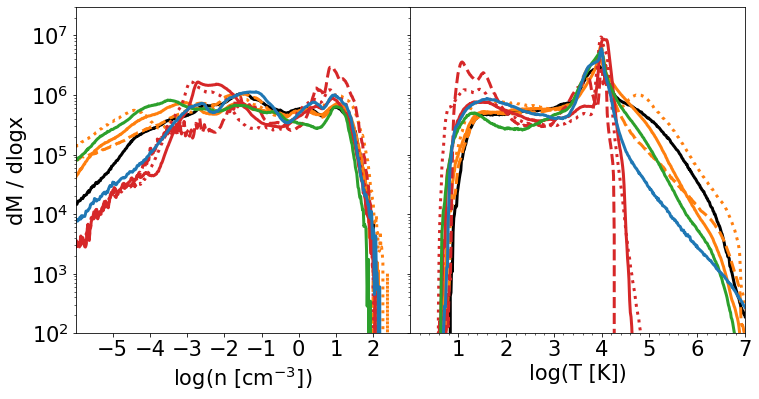

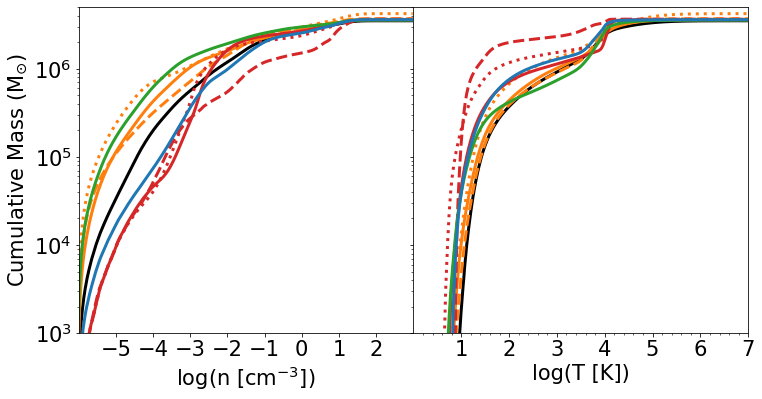

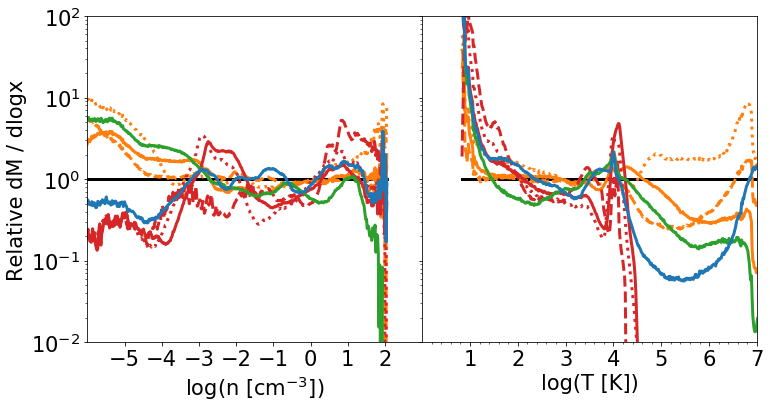

In [81]:
plot_settings()

runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn','fiducial']

runs = base_comparison

phase_type = 'nT_phase_disk'
#phase_type = "nT_phase_outside_disk"


sharey=True

fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)

if sharey:
    fig.subplots_adjust(wspace=0)
#
# plot many panel phase diagram
#


for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), nhist / (np.log10(nbins[1])-np.log10(nbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), Thist / (np.log10(Tbins[1])-np.log10(Tbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(100,3.0E7)
    
if not sharey:
    ax[0].set_ylabel("dM / dlogn")
    ax[1].set_ylabel("dM / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel(r"dM / dlogx")
                     
fig.savefig("1D_phase_plot_" + phase_type + ".png")
plt.show()
plt.close()
#
#
# plot cumulative
#
#



fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)
if sharey:
    fig.subplots_adjust(wspace=0)
for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), np.cumsum(nhist),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), np.cumsum(Thist), # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(1000,5.0E6)
    
ax[0].set_ylabel(r"Cumulative Mass (M$_{\odot}$)")
if not sharey:
    ax[1].set_ylabel(r"Cumulative Mass (M$_{\odot}$)")
    plt.tight_layout()

fig.savefig("1D_phase_plot_cumulative_" + phase_type + ".png")
plt.show()
plt.close()


#
#
# plot fraction
#
#


fig, ax = plt.subplots(1,2,sharey=sharey)
fig.set_size_inches(12,6)
if sharey:
    fig.subplots_adjust(wspace=0)
#phase_type = "nT_phase_outside_disk"

n_norm = all_data['fiducial'].data(phase_type)['1D']['nhist']
T_norm = all_data['fiducial'].data(phase_type)['1D']['Thist']

for i,run in enumerate(runs):    
    
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins[n_norm>0]), nhist[n_norm>0] / n_norm[n_norm>0],# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins[T_norm>0]), Thist[T_norm>0] / T_norm[T_norm>0], # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

for a in ax:
    a.semilogy()
    a.set_ylim(0.01,100.0)
    

if not sharey:
    ax[0].set_ylabel("Relative dM / dlogn")    
    ax[1].set_ylabel("Relative dT / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel("Relative dM / dlogx")

fig.savefig("1D_phase_plot_relative_" + phase_type + ".png")


plt.show()
plt.close()


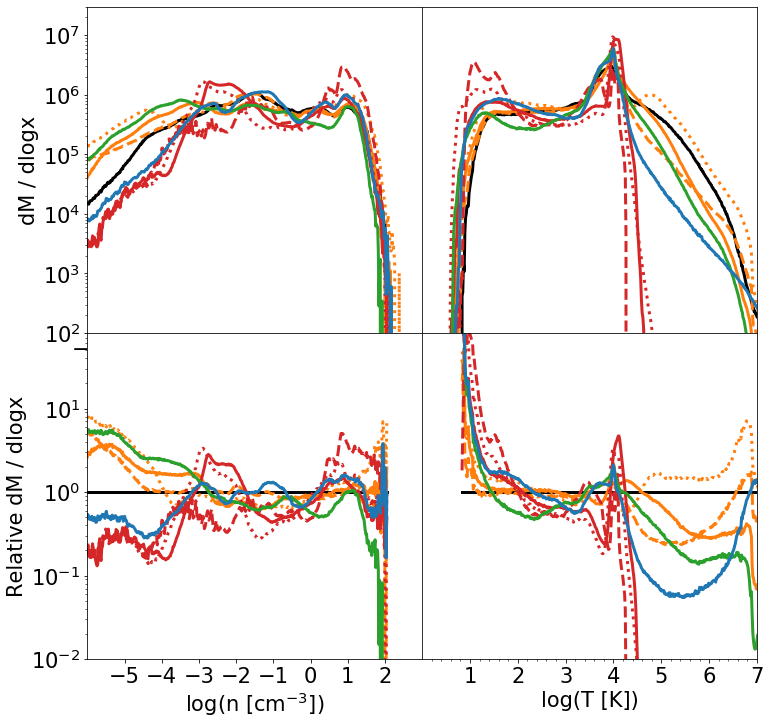

In [92]:
plot_settings()

runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
        'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
        'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn','fiducial']

runs = base_comparison

phase_type = 'nT_phase_disk'
#phase_type = "nT_phase_outside_disk"


sharex,sharey=True,True

fig, all_axes = plt.subplots(2,2)
fig.set_size_inches(12,12)

if sharey:
    fig.subplots_adjust(wspace=0)
if sharex:
    fig.subplots_adjust(hspace=0)
#
# plot many panel phase diagram
#
ax = all_axes[0]

for i,run in enumerate(runs):    
        
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins), nhist / (np.log10(nbins[1])-np.log10(nbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins), Thist / (np.log10(Tbins[1])-np.log10(Tbins[0])),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

    
if not sharex:
    ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
    ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2])
        
if not sharex:
    ax[1].set_xlabel(r"log(T [K])")
    ax[1].set_xticks([1,2,3,4,5,6,7])    

for a in ax:
    a.semilogy()
    a.set_ylim(100,3.0E7)
    
if not sharey:
    ax[0].set_ylabel("dM / dlogn")
    ax[1].set_ylabel("dM / dlogT")
    plt.tight_layout()
else:
    ax[0].set_ylabel(r"dM / dlogx")
    ax[1].get_yaxis().set_visible(False)


#
#
# plot fraction
#
#
ax = all_axes[1]

n_norm = all_data['fiducial'].data(phase_type)['1D']['nhist']
T_norm = all_data['fiducial'].data(phase_type)['1D']['Thist']

for i,run in enumerate(runs):    
    
    if all_data[run].data('nT_phase_disk') is None:
        print("Skipping phase diagram for run " + run)
        continue
        
    phase_data = all_data[run].data(phase_type)
        
    nbins = phase_data['1D']['nbins']
    nhist = phase_data['1D']['nhist']
    Tbins = phase_data['1D']['Tbins']
    Thist = phase_data['1D']['Thist']
    
    ax[0].plot(np.log10(nbins[n_norm>0]), (nhist[n_norm>0]/np.sum(nhist))/ (n_norm[n_norm>0]/np.sum(n_norm)),# where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])
    ax[1].plot(np.log10(Tbins[T_norm>0]), (Thist[T_norm>0]/np.sum(Thist)) / (T_norm[T_norm>0]/np.sum(T_norm)), # where = 'pre',
                      color = colors[run], label = labels[run],lw=3, ls = lstyles[run])

    ax[0].set_xlim(-6,3)
    ax[1].set_xlim(0,7)
    
    
    
    plt.minorticks_on()

ax[0].set_xlabel(r"log(n [cm$^{-3}$])")
ax[0].set_xticks([-5,-4,-3,-2,-1,0,1,2]) 
ax[1].set_xlabel(r"log(T [K])")
ax[1].set_xticks([1,2,3,4,5,6,7])
            
    
for a in ax:
    a.semilogy()
    a.set_ylim(0.01,80.0)

if not sharey:
    ax[0].set_ylabel("Relative dM / dlogn")    
    ax[1].set_ylabel("Relative dT / dlogT")
    plt.tight_layout()
    
else:
    ax[0].set_ylabel("Relative dM / dlogx")
    ax[1].get_yaxis().set_visible(False)

fig.savefig("1D_phase_plot_2panel_" + phase_type + ".png")

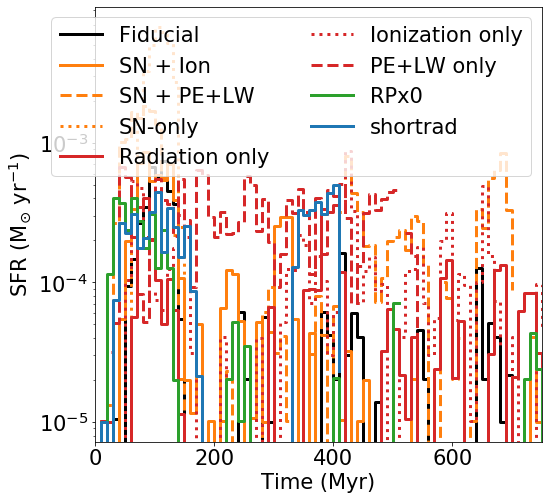

In [11]:
#
# plot a SFR comparison
#
plot_settings()

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(global_time_lim)
#ax.set_ylim()
fig.savefig('physics_comparison_sfr.png')

x = all_data['sn_only']
x.load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') / x.load_field('M_gas')

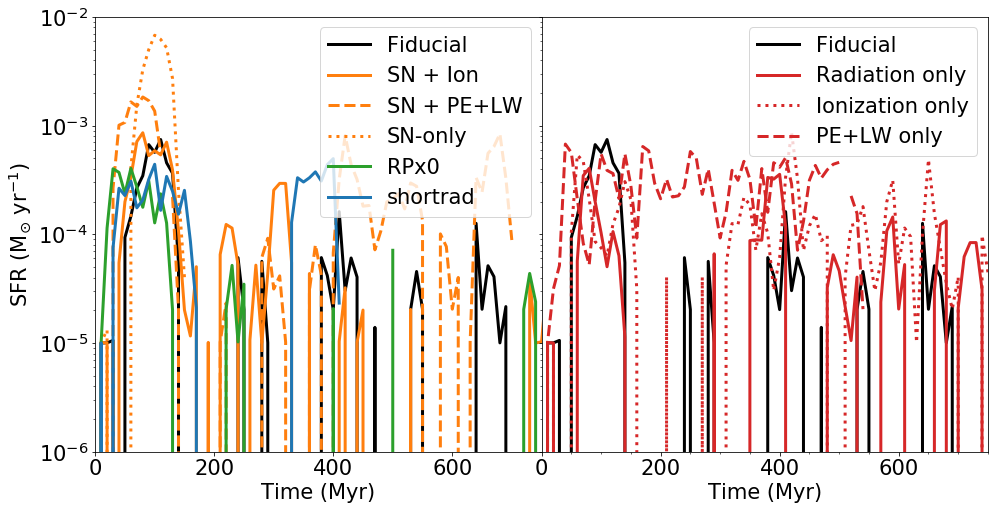

In [12]:
#
# plot a SFR comparison
#
plot_settings()

fig, axes = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

runs_to_plot = base_comparison

ax = axes[0]
runs_to_plot = sn_runs+ misc_runs
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    plt.minorticks_on()


ax = axes[1]
runs_to_plot =  ['fiducial'] + no_sn_runs 
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    #SFR[SFR<1.0E-6]=
    
    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
   
    plt.minorticks_on()
    
for ax in axes:
    ax.set_xlabel(r'Time (Myr)')
    ax.semilogy()
    ax.set_xlim(global_time_lim)
    ax.set_ylim(1.0E-6,1.0E-2)
axes[0].legend(ncol = 1,loc = 'upper right')
axes[1].legend(loc='best',ncol = 1)
axes[0].set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')



#ax.set_ylim()
fig.savefig('physics_comparison_sfr_2.png')

/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


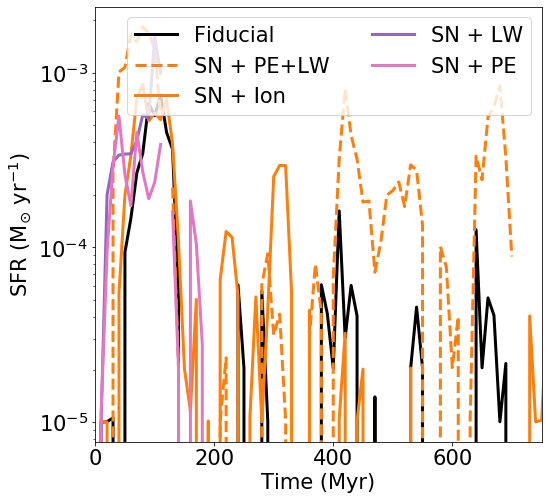

In [10]:
#
# plot a SFR comparison
#
plot_settings()

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

runs_to_plot = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
                
                'snlw', 'snpe']

temp_colors  = {'fiducial' : colors['fiducial'],
                'sn_otrad_no-ion' : colors['sn_otrad_no-ion'],
                 'sn_ion-no-otrad': colors['sn_ion-no-otrad'],
                'snlw' : 'C4',
                'snpe' : 'C6'}

temp_lstyles = {}
for k in runs_to_plot:
    temp_lstyles[k] = lstyles[k]
temp_lstyles['snlw'] = '-'
temp_lstyles['snpe'] = '-'
temp_lstyles['sn_otrad_no-ion'] = '--'

for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    #ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = temp_colors[run], 
                                                                 #     ls    = temp_lstyles[run])
    ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = temp_colors[run], ls=temp_lstyles[run])
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(global_time_lim)
#ax.set_ylim()
fig.savefig('physics_comparison_OT_radiation.png')

fiducial [8.01444284e-04 8.33970534e-04 8.71237116e-04 9.11166820e-04
 8.97775533e-04 9.06328937e-04 9.22763754e-04 9.41815980e-04
 9.67339704e-04 9.95088256e-04 1.02494957e-03 1.05690963e-03
 1.09068156e-03 1.12602461e-03 1.16303921e-03 1.20294035e-03
 1.24351597e-03 1.25556073e-03 1.26185818e-03 1.27615118e-03
 1.29391989e-03 1.31399278e-03 1.33549592e-03 1.35795386e-03
 1.38141345e-03 1.40601584e-03 1.43141453e-03 1.45682819e-03
 1.48197602e-03 1.50690673e-03 1.53848945e-03 1.58293423e-03
 1.63841456e-03 1.68370139e-03 1.56974556e-03 1.46694281e-03
 1.37574324e-03 1.29147990e-03 1.21062949e-03 1.16013337e-03
 1.14123095e-03 1.12480827e-03 1.11035087e-03 1.09778909e-03
 1.09418643e-03 1.11086039e-03 9.70974974e-04 8.02554995e-04
 6.85389173e-04 5.73402460e-04 4.64895337e-04 3.96892078e-04
 3.50125862e-04 3.07612064e-04 2.92700358e-04 2.80793590e-04
 2.69747612e-04 2.60049242e-04 2.40519966e-04 2.18941192e-04
 1.98075878e-04 1.56278673e-04 1.23849309e-04 1.01331404e-04
 8.13334867e-05

 1.04942606e-02 1.05053381e-02 1.05103185e-02 1.04947830e-02]
sn_otrad_no-ion [1.96958703e-03 1.95661705e-03 1.96066879e-03 1.97229918e-03
 1.98845992e-03 2.00770576e-03 2.02921810e-03 2.05307011e-03
 2.07924083e-03 2.10700904e-03 2.13565348e-03 2.16475578e-03
 2.19426045e-03 2.22557831e-03 2.27205130e-03 2.32811195e-03
 2.34330096e-03 2.29505829e-03 2.20030115e-03 2.03134548e-03
 1.86859331e-03 1.56960088e-03 1.35800971e-03 1.15266290e-03
 9.69158866e-04 7.92896949e-04 6.29610650e-04 4.92952141e-04
 3.72488907e-04 2.90988038e-04 2.29629204e-04 1.74256887e-04
 1.34359634e-04 1.03673277e-04 7.80926824e-05 5.18441496e-05
 3.61202164e-05 2.54396121e-05 1.95165390e-05 1.47453475e-05
 1.01647716e-05 6.83905964e-06 4.94315594e-06 4.06934046e-06
 3.43756993e-06 3.36861526e-06 3.65963930e-06 3.98968064e-06
 4.65722538e-06 4.89458735e-06 4.95974223e-06 3.86872308e-06
 2.61719551e-06 1.28919495e-06 7.86126957e-07 6.18273911e-07
 6.17530438e-07 4.44474775e-07 3.28498531e-07 3.15793229e-07
 2.5719

 1.44960172e-03]
sn_ion-no-otrad [0.00077616 0.00082157 0.00086782 0.0009168  0.00096577 0.00101271
 0.00106192 0.00111425 0.00117525 0.0012336  0.00128666 0.00134463
 0.00140307 0.00146237 0.00152271 0.00158291 0.00164592 0.00170977
 0.00177443 0.00183962 0.00190537 0.00196338 0.00203124 0.00209956
 0.00216498 0.00222783 0.00228565 0.0023391  0.00238956 0.00243671
 0.00249384 0.00256017 0.00264371 0.00272245 0.00280015 0.00287648
 0.00295251 0.00302805 0.00311192 0.00318104 0.00327078 0.00335022
 0.00344163 0.00352888 0.00359964 0.00372028 0.00382244 0.0039113
 0.00403138 0.00413821 0.00424389 0.00438159 0.00451238 0.00464973
 0.00476735 0.00488096 0.00499321 0.00509201 0.00522021 0.00533587
 0.00544428 0.00555441 0.0056346  0.00576909 0.00587627 0.00596568
 0.00607801 0.00621748 0.00633666 0.00649221 0.00660028 0.00668155
 0.00675876 0.00673665 0.00683566 0.00695374 0.00700676 0.00710597
 0.00709682 0.00718706 0.00733023 0.00733957 0.00735258 0.00741633
 0.00829936 0.00758213 0.00756

 0.02604552 0.02614435 0.02624615 0.02636025 0.02646912 0.02656548]
snlw [0.0024821  0.00651367 0.01489078 0.02845817 0.04414714 0.05546333
 0.06440995 0.07157697 0.07735463 0.08249795 0.08816816 0.09339954
 0.09905197 0.10407289 0.10650985 0.10829285 0.11041114 0.11198474
 0.1144841  0.11871317 0.12357205 0.12548698 0.12606673 0.1282884
 0.13158324 0.13636532 0.14293057 0.14955365 0.15581394 0.16206805
 0.16829034 0.17487531 0.18166571 0.18794769 0.19357198 0.19826996
 0.20255124 0.20710009 0.21090552 0.21526462 0.2174056  0.22035077
 0.22472096 0.22869394 0.2339456  0.23758535 0.24303541 0.24843582
 0.25371521 0.25935705 0.26145607 0.26319865 0.26626922 0.26902579
 0.26853184 0.2661428  0.26126365 0.25919226 0.25768816 0.25755388
 0.25895084 0.26041612 0.26426463 0.26825994 0.27126961 0.27400954
 0.27708752 0.27735144 0.27098589 0.2644379  0.26074094 0.26050806
 0.26106531 0.25789074 0.2576202  0.25927413 0.26295159 0.26644965
 0.26602799 0.26673389 0.25950809 0.24959415 0.23948095 0

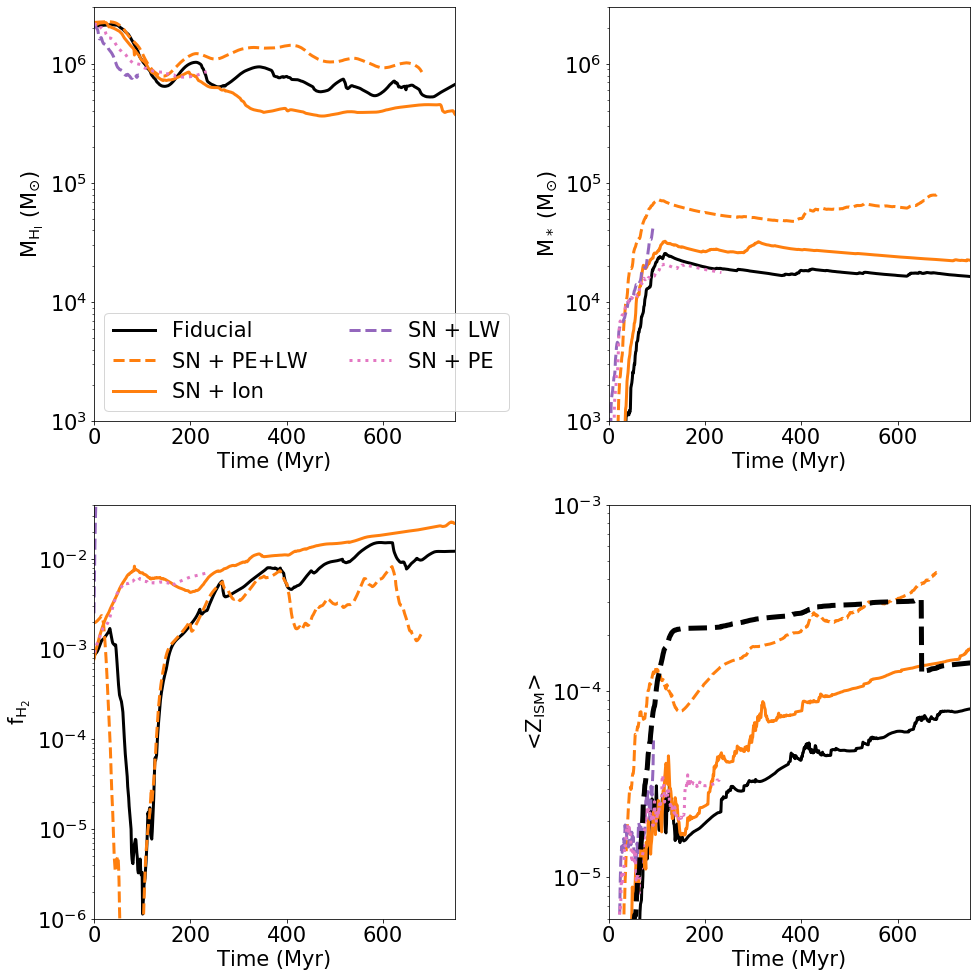

In [13]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 7
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
             r'f$_{\rm H_2}$', 
             r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,1.0E-3]]             

runs_to_plot = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
                'snlw', 'snpe']

index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
               # y = all_data[run].data('M_star')
                
            elif ax_fields[index] == 'M_H2_total':
                y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
                print(run,y)
            else:
                
                y = all_data[run].data(ax_fields[index])
            
            x = x - x[0]

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(global_time_lim)
        ax2.semilogy()
        ax2.set_ylim(ylims[index])
        
        ax2.tick_params(axis='x', which='minor', bottom=True)
        #ax2.tick_params(axis='y', which='minor', bottom=True)

        
        
        index = index + 1
 
             
        axj = axj + 1
        
    axi = axi + 1
    
    
closed_box = True

# overplot closed box model for fiducial run
if closed_box:
    y = all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals') +\
        all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
    #print(y)
    y = y / all_data['fiducial'].load_field('M_gas')[0]
    x = all_data['fiducial'].load_field('time')
    
    axes[(1,1)].plot(x - x[0], y, color = 'black', ls = '--', lw = 5, label = 'Closed Box')
   # axes[(1,1)].legend(loc='best')
    

axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("physics_comparison_masses_OT.png")

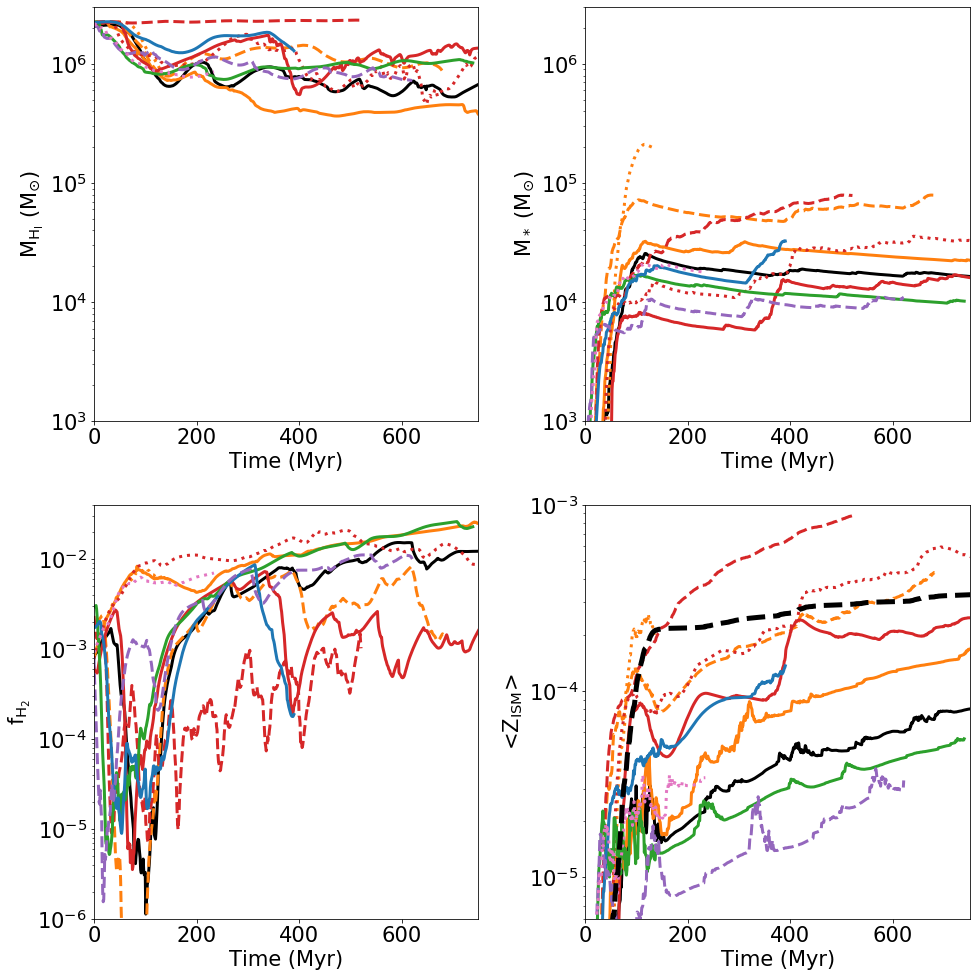

In [58]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 7
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
             r'f$_{\rm H_2}$', 
             r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,1.0E-3]]             

runs_to_plot = base_comparison + ['snlw','snpe']


index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
               # y = all_data[run].data('M_star')
                
            elif ax_fields[index] == 'M_H2_total':
                y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
            else:
                
                y = all_data[run].data(ax_fields[index])
            
            x = x - x[0]

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(global_time_lim)
        ax2.semilogy()
        ax2.set_ylim(ylims[index])
        
        ax2.tick_params(axis='x', which='minor', bottom=True)
        #ax2.tick_params(axis='y', which='minor', bottom=True)

        
        
        index = index + 1
 
             
        axj = axj + 1
        
    axi = axi + 1
    
    
closed_box = True

# overplot closed box model for fiducial run
if closed_box:
    y = 1.0*all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals')
    #print(y[649] - y[650])
    
    y[650:] = y[650:] + 513.927    
    
    y = y +  all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
    y = y / all_data['fiducial'].load_field('M_gas')[0]
    x = all_data['fiducial'].load_field('time')
    
    axes[(1,1)].plot(x - x[0], y, color = 'black', ls = '--', lw = 5, label = 'Closed Box')
   # axes[(1,1)].legend(loc='best')
    

#axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("physics_comparison_masses.png")

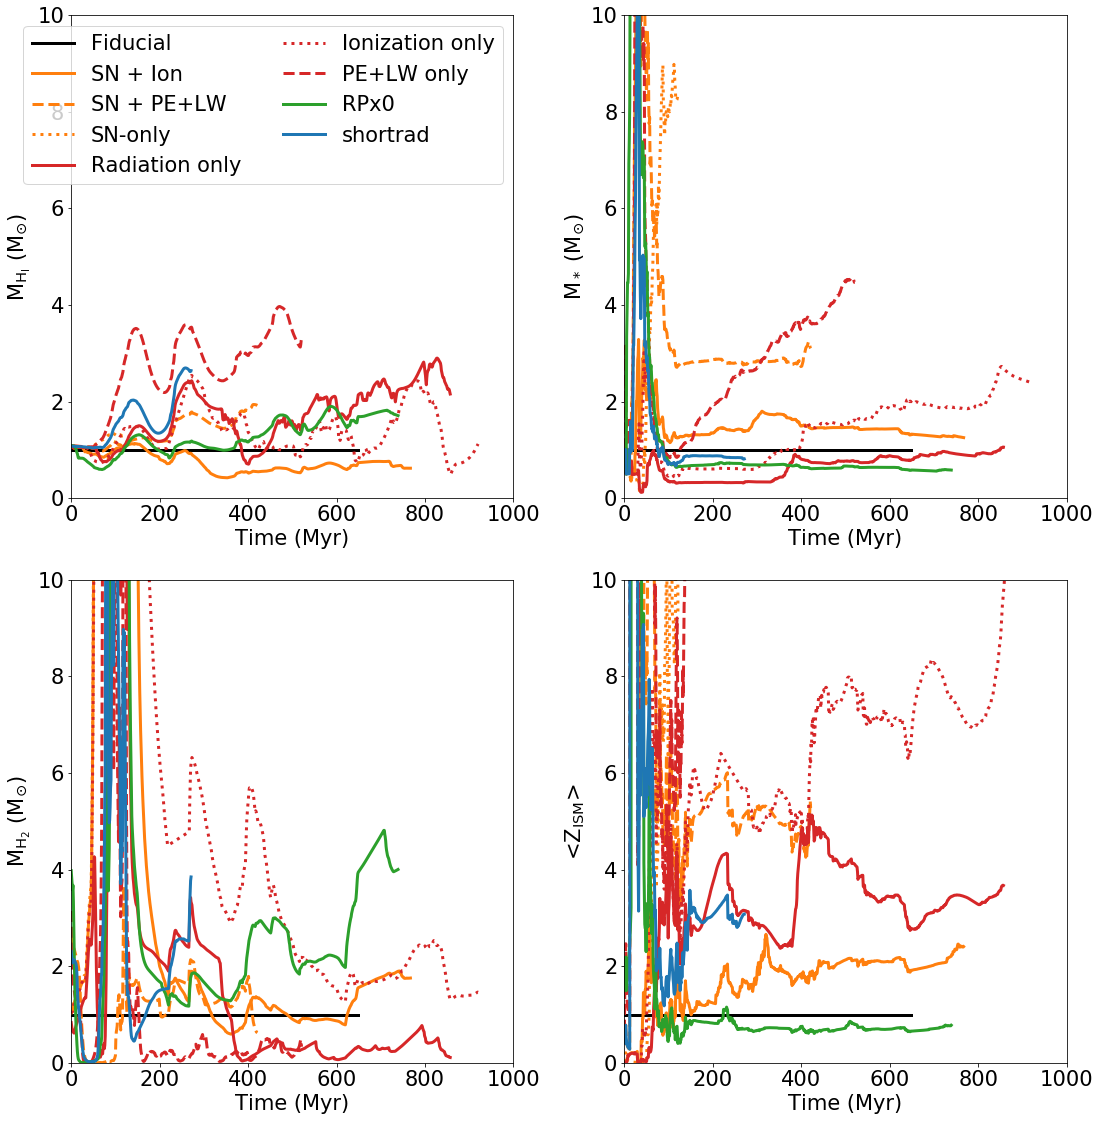

In [68]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 8
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             r'M$_{\rm H_2}$ (M$_{\odot}$)', r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E4,6.0E6], [1.0E3,3.0E5], [1.0,5.0E4], [1.0E-5,3.0E-3]]  


ylims = [ [1.0E-2,1.0E2],  [1.0E-2,1.0E2], [1.0E-2,1.0E2], [1.0E-2,1.0E2] ]            


runs_to_plot = base_comparison


index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            x_fiducial = all_data['fiducial'].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
                
                y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data['fiducial'].data('M_gas')
            else:
                y = all_data[run].data(ax_fields[index])
                
                y_fiducial   = all_data['fiducial'].data(ax_fields[index])
            
            
                    
            x = x - x[0]
            x_fiducial = x_fiducial - x_fiducial[0]
            
            f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
            
            y = y / f_fiducial(x)

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(0.0,1000.0)
        #ax2.semilogy()
        ax2.set_ylim(0.0,10.0)
        #ax2.set_ylim(ylims[index])
        
        
        
        
        index = index + 1

        
             
        axj = axj + 1
        
    axi = axi + 1

axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("normalized_physics_comparison_masses.png")

0.10797193610285677
0.46988158641896705


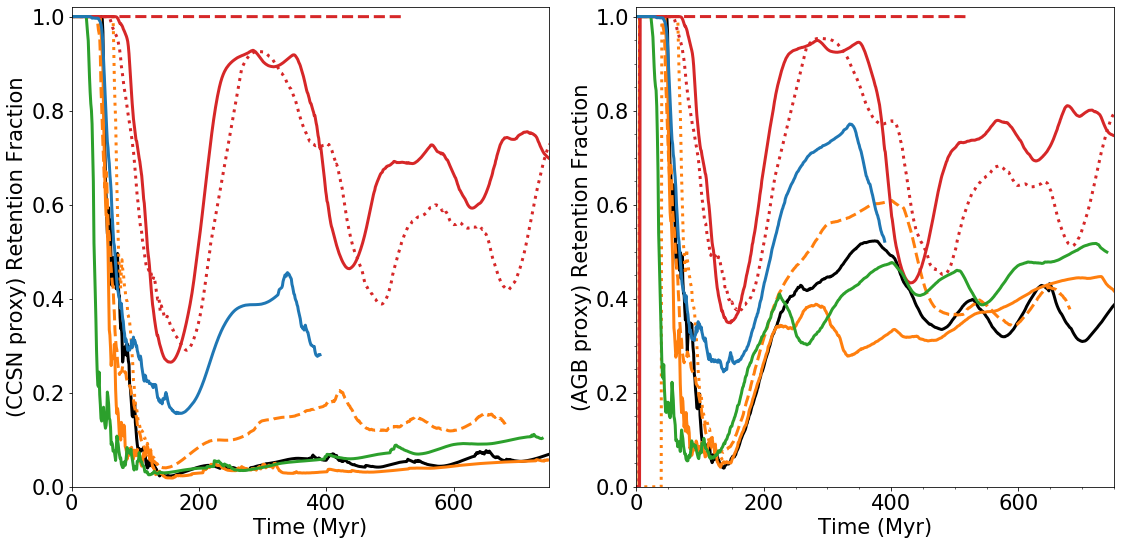

In [133]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0, 1.02) #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_retention.png")

In [17]:
#all_data['shortrad'].load_field('/gas_meta_data/masses/OutsideBox/O')
#
# I think this is a units issue with the newly computed data. I think I fixed the old bug
# in ENzo in gearing up for new runs but didn't update analysis scripts oops. need to do this...
# alternatively, just go through and fix ALL output DDXXXX/DDXXXX with correct units and 
# never do this again.

0.2521097489940249
0.3054578341529213


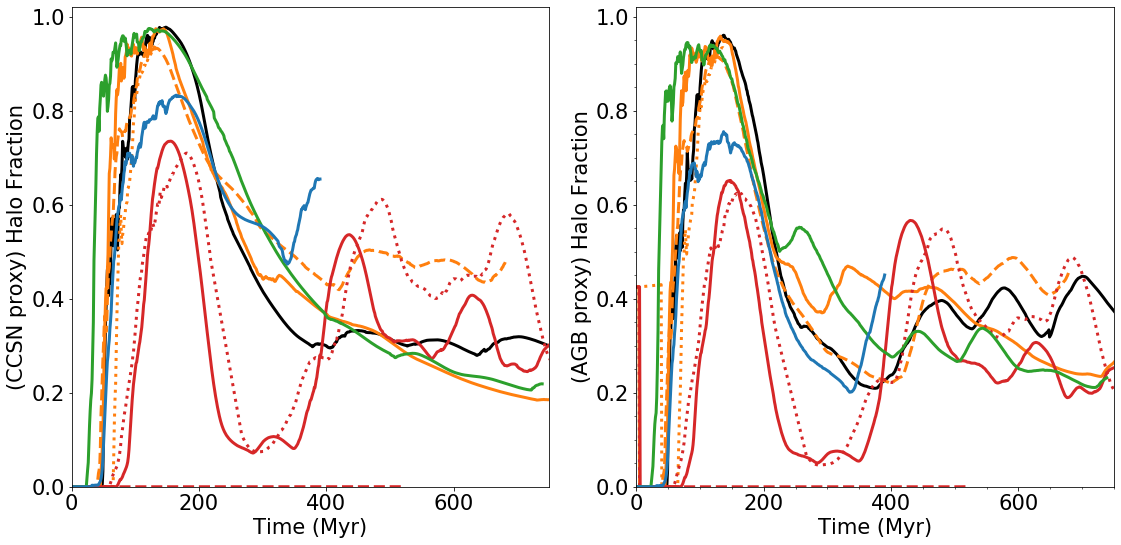

In [134]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Halo/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Halo/Ba')
    
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0, 1.02) #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Halo Fraction')
ax[1].set_ylabel(r'(AGB proxy) Halo Fraction')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()
              Eta_{metal,cold}  8.876E-02

fig.savefig("physics_comparison_halo_fraction.png")

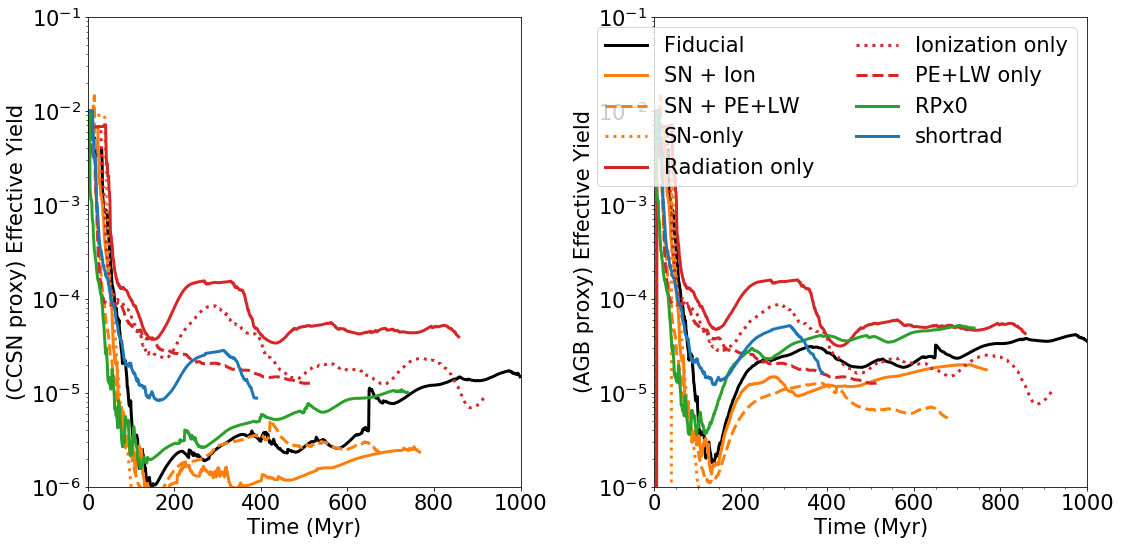

In [24]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_star = all_data[run].load_field('M_star')
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    #if run == 'fiducial':
    #    ax[0].plot(t, M_tot / M_star, label='Onezone', lw=3,color='black',ls='--')
        
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    ax[1].plot(t, (M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    
    
    #if run == 'fiducial':
        #print(M_tot/M_star)
        #ax[1].plot(t, M_tot / M_star, label='Onezone', lw=3,color='black',ls='--')

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.semilogy()
    a.set_ylim(1.0E-6,1.0E-1)
  #  a.set_ylim() #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Effective Yield')
ax[1].set_ylabel(r'(AGB proxy) Effective Yield')

#ax.semilogy()

ax[1].legend(loc='upper right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_yield.png")

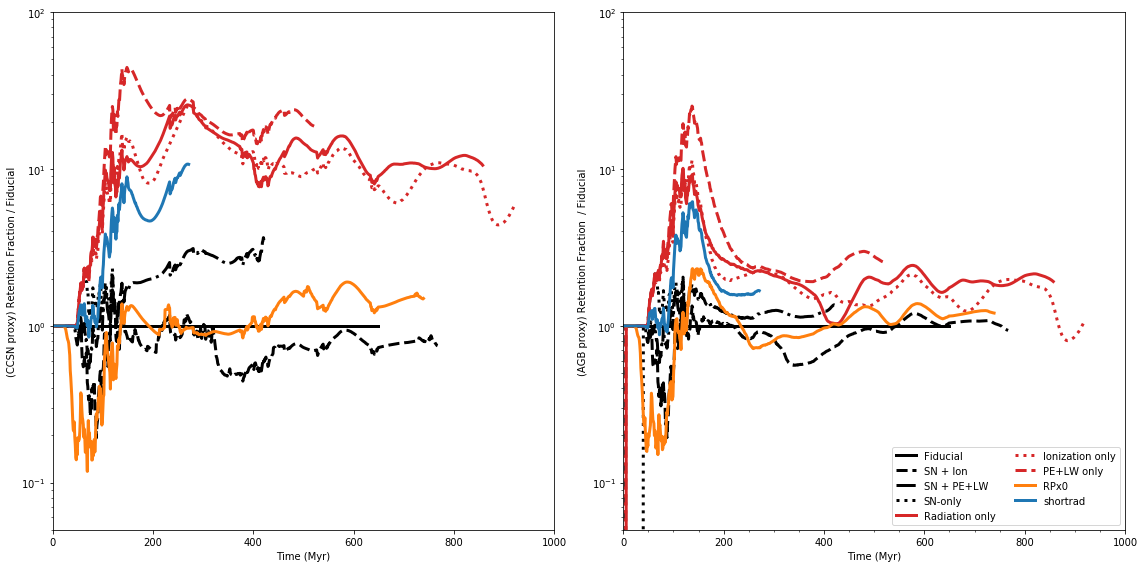

In [9]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    x_fiducial = all_data['fiducial'].data('time')
    
    t = t - t[0]
    x_fiducial = x_fiducial - x_fiducial[0]
    
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/O')/(  
                     all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/O') +\
                     all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/O'))
    f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
    
    
    ax[0].plot(t, ( M_disk / M_tot) / (f_fiducial(t)),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/Ba')/(
                     all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Ba') +\
                     all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Ba'))
    
    f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
    
    ax[1].plot(t, (M_disk / M_tot)/ (f_fiducial(t)),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.set_ylim(5.0E-2,1.0E2) #   'shortrad',
    a.semilogy()
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction / Fiducial')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction  / Fiducial')

#ax.semilogy()

ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("normalized_physics_comparison_retention.png")

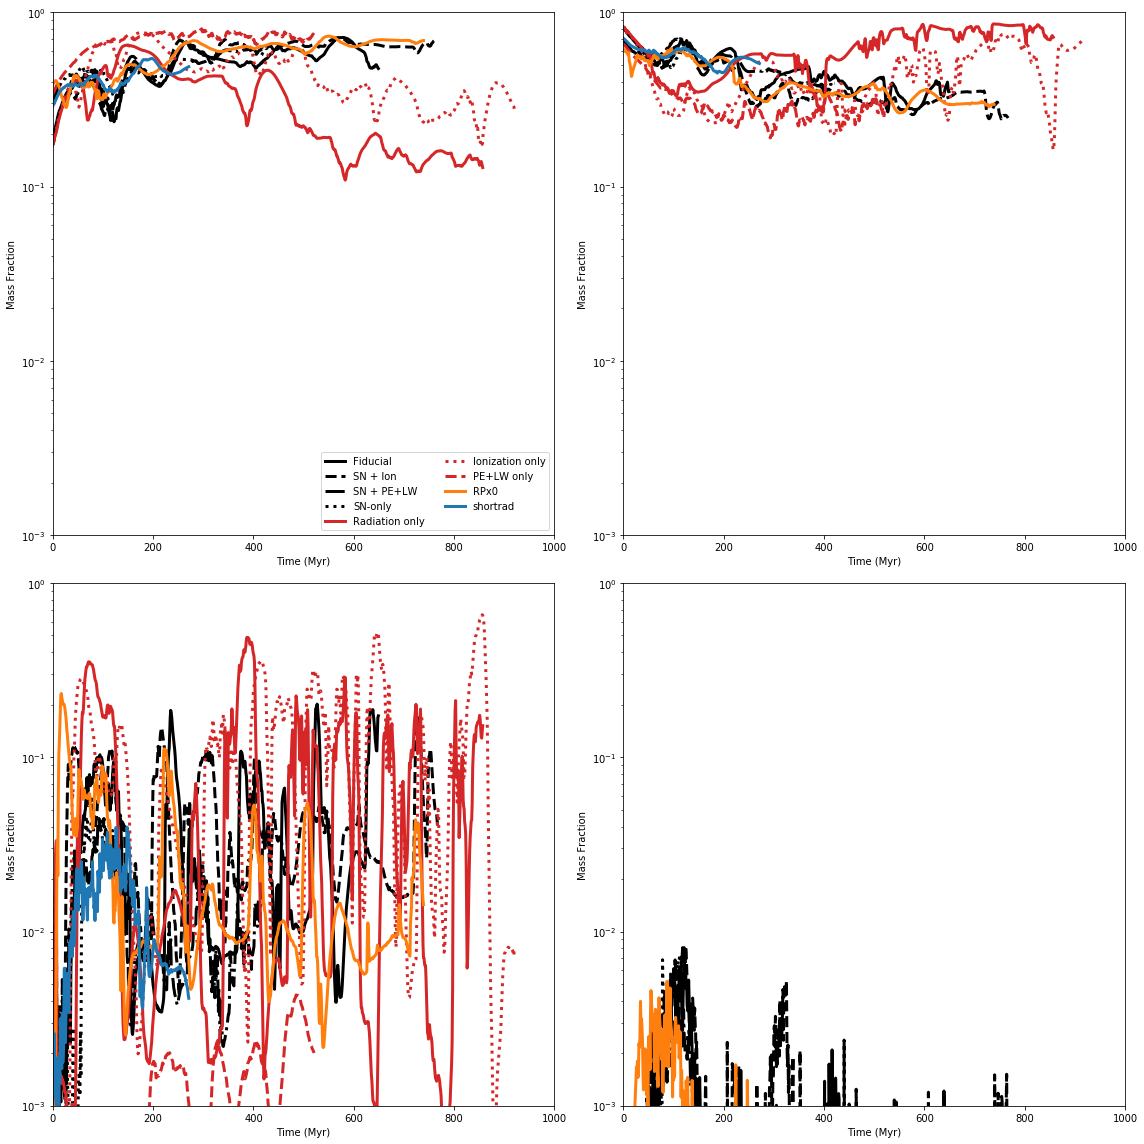

In [10]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Mass Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

fiducial
Failed more than 11 times loading with path /gas_meta_data/volume_fraction/Disk/Total and label /gas_meta_data/volume_fraction/Disk/Total


RuntimeError: 

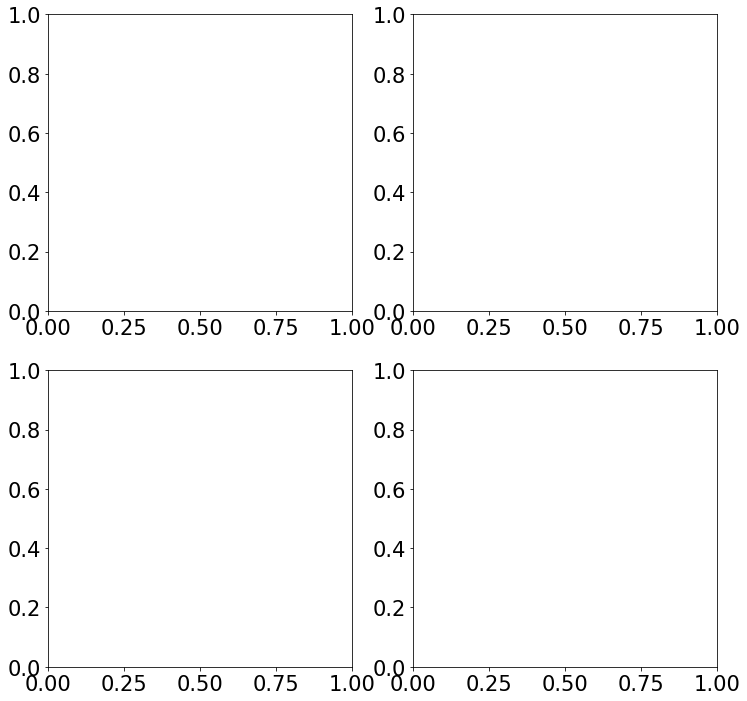

In [26]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume_fraction/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Volume Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

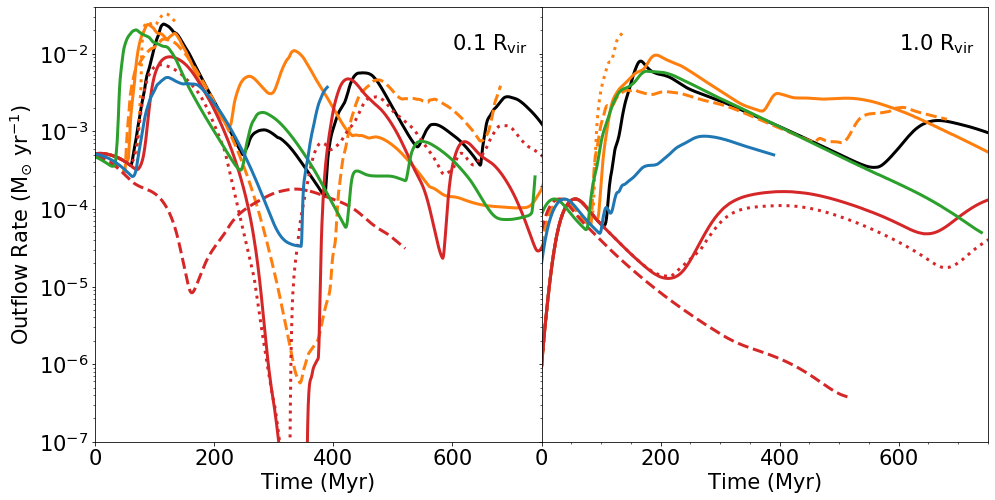

In [162]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")
    
    #print(run,len(outflow), len(all_data[run].data('SFR_100')))

    SFR = 1.0 # np.average(all_data[run].data('SFR_100')[:500])
    
    ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(1.0E-7,0.04) #   'shortrad',
    a.semilogy()
    
#ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

xy=(.8,.9)
ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

ax[0].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
#plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_outflow.png")

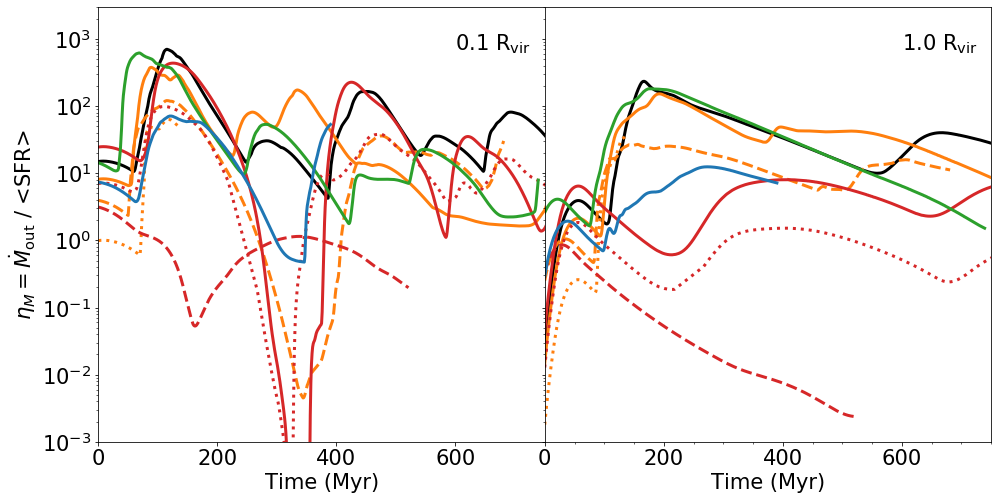

In [54]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")
    
    #print(run,len(outflow), len(all_data[run].data('SFR_100')))

    SFR = np.average(all_data[run].data('SFR_100')[:500])
    
    ax[0].plot(t, outflow[:,0] / SFR, # bin 0 centered on 0.1 Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    ax[1].plot(t, outflow[:,3] / SFR, # bin 5 centered on Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0.001, 3000) #   'shortrad',
    a.semilogy()
    
ax[0].set_ylabel(r'$\eta_M = \dot{M}_{\rm out}$ / <SFR>')

xy=(.8,.9)
ax[0].annotate(r"0.1 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')
ax[1].annotate(r"1.0 R$_{\rm vir}$", xy=xy,xytext=xy,xycoords='axes fraction')

#ax[1].set_ylabel(r'Outflow Rate (M$_{\sun}$ yr$^{-1}$)')'

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
#plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_outflow_loading.png")

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log10


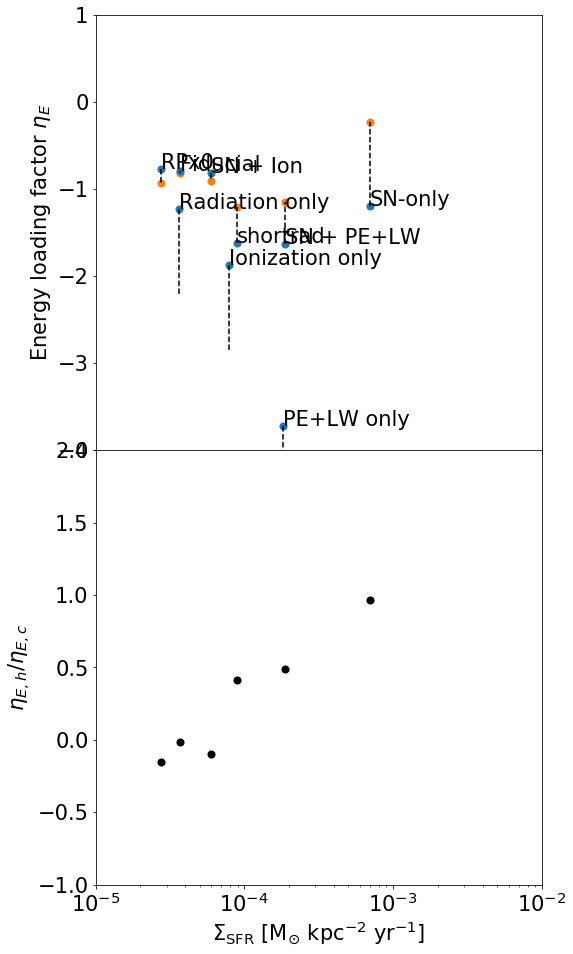

In [94]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 50
#markers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#           'sn_ion-no-otrad' : 'd',
           

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(8,16)
fig.subplots_adjust(hspace=0)

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_hot'])
    ax[0].scatter( x,
                   y,
                   color = 'C1', s = psize, label = run, marker='o')# markers[run] )

    x = all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_cold'])
    xy = (x,y)
    ax[0].scatter( x,y,
                   color = 'C0', s = psize, label = run, marker ='o')
    xy = (x,y)
    ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
    yline = np.log10(yline)        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    x =all_data[run].loading_table_values['Sigma_sfr']
    y = np.log10(all_data[run].loading_table_values['Eta_E_hot_cold_ratio'])

    ax[1].scatter(x,y,
                   color = 'black', s = psize, label = run, marker ='o')
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
   # a.semilogy()
    a.set_xlim(1.0E-5,0.01)
    
ax[0].set_ylim(-4,1)
ax[1].set_ylim(-1,2)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Energy loading factor $\eta_E$")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")
#plt.tight_layout()
fig.savefig("phys_comparison_etaE_hot_cold_SFR.png")


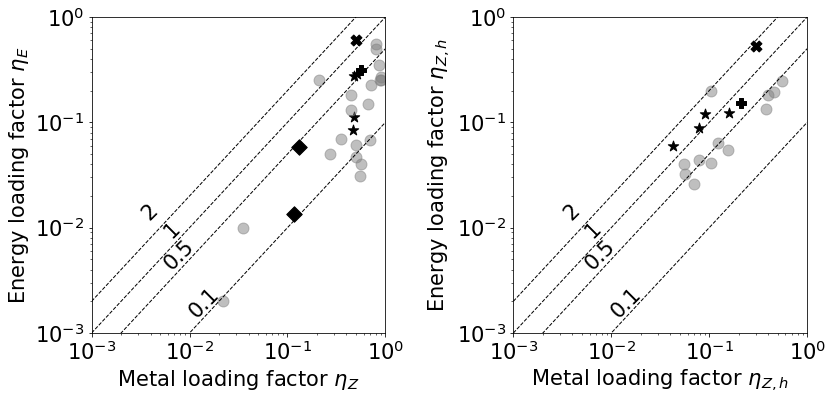

In [303]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
#fig.subplots_adjust(hspace=0)


LI = { 'Eta_Z_total' :[0.716,
0.668,
0.894,
0.44,
3.53E-01,
5.00E-01,
2.71E-01,
6.92E-01,
5.00E-01,
5.45E-01,
5.66E-01,
0.21,
0.035,
0.9,
0.8,
0.8,
0.85,
0.87,
0.45,
2.20E-02],
      'Eta_Z_hot' : [0.46,
0.376,
0.55,
0.4,
1.22E-01,
0.1563,
0.0781,
0.0554,
1.04E-01,
7.07E-02,
0.0563,
0.104],
      'Eta_E_total' : [0.224,
0.148,
0.268,
0.18,
6.87E-02,
6.10E-02,
5.02E-02,
6.77E-02,
4.69E-02,
3.09E-02,
4.05E-02,
0.25,
0.01,
0.25,
0.5,
0.55,
0.35,
0.25,
0.13,
2.00E-03],
      'Eta_E_hot' : [0.196,
0.134,
0.244,
0.18,
6.30E-02,
5.50E-02,
4.40E-02,
4.00E-02,
4.10E-02,
2.60E-02,
3.20E-02,
0.2] }

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal']
    y = all_data[run].loading_table_values['Eta_E']
        
    ax[0].scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

    
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal_hot']
    y = all_data[run].loading_table_values['Eta_E_hot']
        
    ax[1].scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

lw_2 = 1.0
    
for a in ax:

    a.set_xlim(1.0E-3,1.0)
    a.set_ylim(1.0E-3, 1.0)
    
    a.semilogy()
    a.semilogx()
    
    
    a.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
    xy = (0.003,0.012) 
    a.text(xy[0], xy[1] , r'2', rotation = 45)    
    a.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
    xy = (0.005,0.008) 
    a.text(xy[0], xy[1] , r'1', rotation = 45)
    a.plot( [1.0E-3,1.0], [5.0E-4,0.5], lw = lw_2, ls = '--',color='black')
    xy = (0.005,0.0040) 
    a.text(xy[0], xy[1] , r'0.5', rotation = 45)    
    a.plot( [1.0E-3,1.0], [1.0E-4,0.1], lw = lw_2, ls = '--',color='black')
    xy = (0.009,0.0014) 
    a.text(xy[0], xy[1] , r'0.1', rotation = 45)      
    #a.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')    

ax[0].set_xlabel("Metal loading factor $\eta_Z$")    
ax[0].set_ylabel("Energy loading factor $\eta_E$")
ax[1].set_xlabel("Metal loading factor $\eta_{Z,h}$")    
ax[1].set_ylabel("Energy loading factor $\eta_{Z,h}$")


ax[1].scatter( LI['Eta_Z_hot'], LI['Eta_E_hot'], color = 'grey', s = psize, marker = 'o', alpha = 0.5,
            label = 'Li & Bryan 2020')
ax[0].scatter( LI['Eta_Z_total'], LI['Eta_E_total'], color = 'grey', s = psize, marker = 'o', alpha = 0.5)

plt.tight_layout()
fig.savefig("phys_comparison_E_loading_Z_loading.png")

Eta_Z_total 20
Eta_Z_hot 12
Eta_E_total 20
Eta_E_hot 12


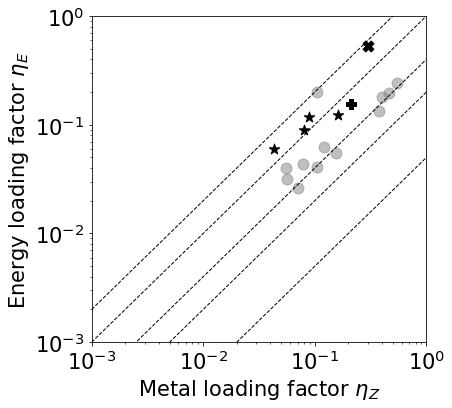

In [272]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)


xmin, xmax = 999999999,-999999999
ymin, ymax = 999999999,-999999999
for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal_hot']
    y = all_data[run].loading_table_values['Eta_E_hot']
        
    ax.scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

    xmin = np.min([x, xmin])
    xmax = np.max([x, xmax])
    ymin = np.min([y, ymin])
    ymax = np.max([y, ymax])


ax.set_ylabel("Energy loading factor $\eta_E$")
ax.set_xlabel("Metal loading factor $\eta_Z$")
ax.semilogy()
ax.semilogx()

ax.set_xlim(1.0E-3,1.0)
ax.set_ylim(1.0E-3, 1.0)

lw_2 = 1.0

ax.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [4.0E-4,0.4], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [2.0E-4,0.2], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')
ax.scatter( LI['Eta_Z_hot'], LI['Eta_E_hot'], color = 'grey', s = psize, marker = 'o', alpha = 0.5,
            label = 'Li & Bryan 2020')

#ax.scatter(all_data['fiducial-1.8pc'].loading_table_values['Eta_metal_hot'],
#           all_data['fiducial-1.8pc'].loading_tables_values['Eta_E_hot'], color ='C3')

fig.savefig("phys_comparison_hot_E_loading_Z_loading.png")

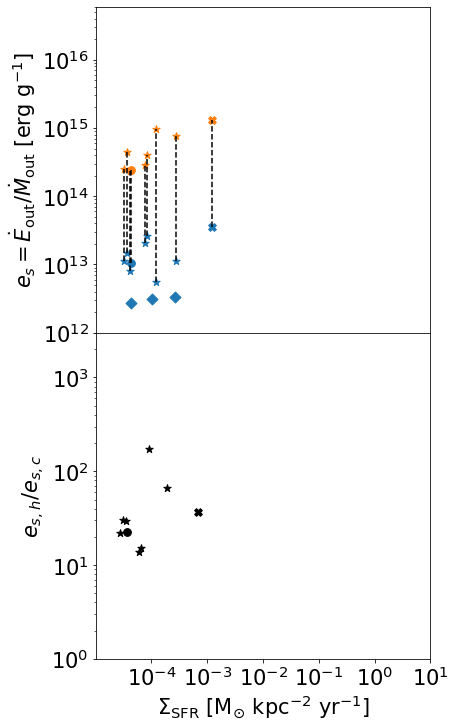

In [160]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 60
#markers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(6,12)
fig.subplots_adjust(hspace=0)

for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue
        
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    
    yline = [all_data[run].loading_table_values['e_s_cold'],
             all_data[run].loading_table_values['e_s_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
        
        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot_cold_ratio'],
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
    a.semilogy()
    a.set_xlim(1.0E-5,2)
    
ax[0].set_ylim(1.0E12,6.0E16)
ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"$e_s = \dot{E}_{\rm out} / \dot{M}_{\rm out}$ [erg g$^{-1}$]")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$e_{s,h} / e_{s,c}$")

ax[1].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
plt.minorticks_on()

#plt.tight_layout()
fig.savefig("phys_comparison_e_s_hot_cold_SFR.png")


fiducial 0.5639000000000001
sn_ion-no-otrad 0.4826
sn_otrad_no-ion 0.47512999999999994
sn_only 0.5003
otrad_ion-no-sn 0.1299
ion_no-otrad-sn 0.1176
otrad_no-ion-sn 1.856e-14
sn_otrad_ion_noRP 0.5154
shortrad 0.46616


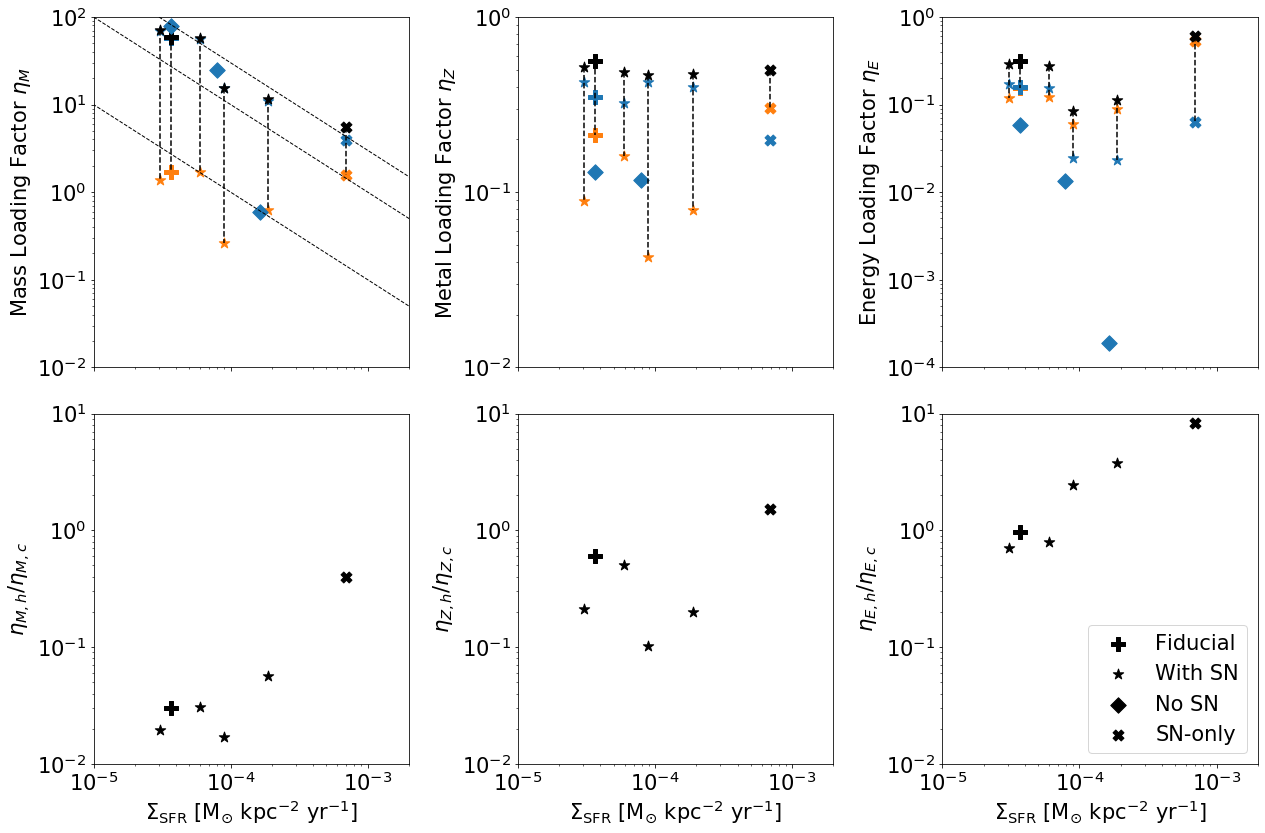

In [261]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)
total_color = 'black'


psize = 120
#arkers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,3,sharex=True)
fig.set_size_inches(18,12)
fig.subplots_adjust(hspace=0,wspace=0.25)

sfr_dict = {}

for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
        
    if run == 'fiducial':
        psize = 180
    else:
        psize = 120
        
    sfr_dict[run] = all_data[run].loading_table_values['Sigma_sfr']

    if run == 'otrad_no-ion-sn':
        sfr_dict[run] = sfr_dict[run]*0.9 # minor fudge for aesthetic...
    elif run == 'sn_otrad_ion_noRP':
        sfr_dict[run] = sfr_dict[run]*1.1
    
    ax[(0,0)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,0)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    #ax[(0,0)].scatter( sfr_dict[run],
    #               all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
    #               color = total_color, s = psize, label = run, marker = markers[run])   
    
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ sfr_dict[run]]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,0)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    else:
        yline[0] = yline[1] + yline[0]
        
        ax[(0,0)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,0)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[(0,1)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,1)].scatter( sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])   
    #ax[(0,1)].scatter( sfr_dict[run],
    #               all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
    #               color = total_color, s = psize, label = run, marker = markers[run])      
    #print(run,all_data[run].loading_table_values['Sigma_sfr'],all_data[run].loading_table_values['Eta_metal_cold'])
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ sfr_dict[run] ]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,1)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    else:
        yline[0] = yline[1] + yline[0]
        ax[(0,1)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,1)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    yratio = all_data[run].loading_table_values['Eta_mass_hot'] /\
             all_data[run].loading_table_values['Eta_mass_cold']
    
    ax[(1,0)].scatter( sfr_dict[run],
                   yratio,
                   color = 'black', s = psize, label = run, marker = markers[run])
   
    print(run, all_data[run].loading_table_values['Eta_metal_cold']+all_data[run].loading_table_values['Eta_metal_hot'])

    yratio = all_data[run].loading_table_values['Eta_metal_hot'] /\
             all_data[run].loading_table_values['Eta_metal_cold']
    
    ax[(1,1)].scatter( sfr_dict[run],
                   yratio,
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
############

    x = sfr_dict[run]
    y = all_data[run].loading_table_values['Eta_E_hot']
    ax[(0,2)].scatter( x,
                   y,
                   color = 'C1', s = psize, label = run, marker=markers[run])# markers[run] )

    y = all_data[run].loading_table_values['Eta_E_cold']
    xy = (x,y)
    ax[(0,2)].scatter( x,y,
                   color = 'C0', s = psize, label = run, marker = markers[run])
    #ax[(0,2)].scatter( x , all_data[run].loading_table_values['Eta_E_hot'] +  all_data[run].loading_table_values['Eta_E_cold'],
    #               color = total_color, s = psize, label = run, marker = markers[run])    
    #xy = (x,y)
    #ax[(0,2)].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ sfr_dict[run] ]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        #temp = ax[(0,2)].errorbar(sfr_dict[run], yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        #temp[-1][0].set_linestyle('--')
    
    else:
        yline[1] = np.min([all_data[run].loading_table_values['Eta_E_cold'],all_data[run].loading_table_values['Eta_E_hot']])
        yline[0] = np.sum([all_data[run].loading_table_values['Eta_E_cold'],all_data[run].loading_table_values['Eta_E_hot']])
        
        ax[(0,2)].scatter(sfr_dict[run],
                   all_data[run].loading_table_values['Eta_E_cold'] + all_data[run].loading_table_values['Eta_E_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[(0,2)].plot( xline,
                        yline,
                        lw = 1.5, color = 'black',
                        ls = '--')
        
        
    y = all_data[run].loading_table_values['Eta_E_hot_cold_ratio']

    ax[(1,2)].scatter(x,y,
                   color = 'black', s = psize, marker = markers[run])

# marker labels
ax[(1,2)].scatter(-1,-1,color='black',s=180, marker = 'P', label = 'Fiducial')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = '*', label = 'With SN')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 'D', label = 'No SN')
ax[(1,2)].scatter(-1,-1,color='black',s=psize, marker = 'X', label = 'SN-only')



for a2 in ax:
    for a in a2:
        a.semilogx()
        a.semilogy()
        a.set_xlim(1.0E-5,0.002)
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[(0,0)].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[(0,1)].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[(0,2)].set_ylabel(r"Energy Loading Factor $\eta_E$")

ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,2)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")
ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")
ax[(1,2)].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")

#ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
#ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[(0,0)].set_ylim(1.0E-2,100.0)
ax[(0,1)].set_ylim(1.0E-2,1.0)
ax[(0,2)].set_ylim(1.0E-4,1.0)

ax[(1,0)].set_ylim(0.01,10.0)
ax[(1,1)].set_ylim(0.01,10.0)
ax[(1,2)].set_ylim(0.01,10.0)

ax[(1,2)].legend(loc='lower right')


ax[(0,0)].plot([1.0E-5,1.0E-1],[100.0,0.01],lw=1,ls='--',color='black')
ax[(0,0)].plot([3.0E-5,0.3],   [100.0,0.01],lw=1,ls='--',color='black')
ax[(0,0)].plot([1.0E-6,0.01],   [100.0,0.01],lw=1,ls='--',color='black')

#ax[(0,1)].plot([1.0E-5,1.0E-1],[1.0,0.01],lw=1,ls='--',color='black')
#ax[(0,1)].plot([3.0E-5,0.3],   [1.0,0.01],lw=1,ls='--',color='black')
#ax[(0,1)].plot([1.0E-6,0.01],   [1.0,0.01],lw=1,ls='--',color='black')

plt.tight_layout()
fig.savefig("phys_comparison_mass_metal_hot_cold_SFR.png")


In [169]:
indexes = np.argsort( np.array(list( sfr_dict.values())))



for i in indexes:
    print("%30s    %5.5E"%( list(sfr_dict.keys())[i], list(sfr_dict.values())[i] ))    


                 shortrad_72pc    -9.99000E+02
                          snlw    -9.99000E+02
             sn_otrad_ion_noRP    2.76800E-05
             sn_otrad_ion_RPx2    3.11100E-05
             sn_otrad_ion_RPx5    3.48700E-05
               otrad_ion-no-sn    3.65400E-05
                      fiducial    3.67700E-05
               sn_ion-no-otrad    5.96700E-05
                          snpe    6.53200E-05
               ion_no-otrad-sn    7.89700E-05
                      shortrad    8.90400E-05
               otrad_no-ion-sn    1.83200E-04
               sn_otrad_no-ion    1.88700E-04
                       sn_only    6.95300E-04


In [250]:
markers

{'sn_only': 'X',
 'ion_no-otrad-sn': 'D',
 'otrad_ion-no-sn': 'D',
 'otrad_no-ion-sn': 'D',
 'shortrad': '*',
 'shortrad_72pc': '*',
 'sn_ion-no-otrad': '*',
 'sn_otrad_no-ion': '*',
 'snlw': '*',
 'snpe': '*',
 'sn_otrad_ion_RPx2': '*',
 'sn_otrad_ion_RPx5': '*',
 'sn_otrad_ion_noRP': '*',
 'fiducial-1.8pc': 'P',
 'fiducial': 'P'}

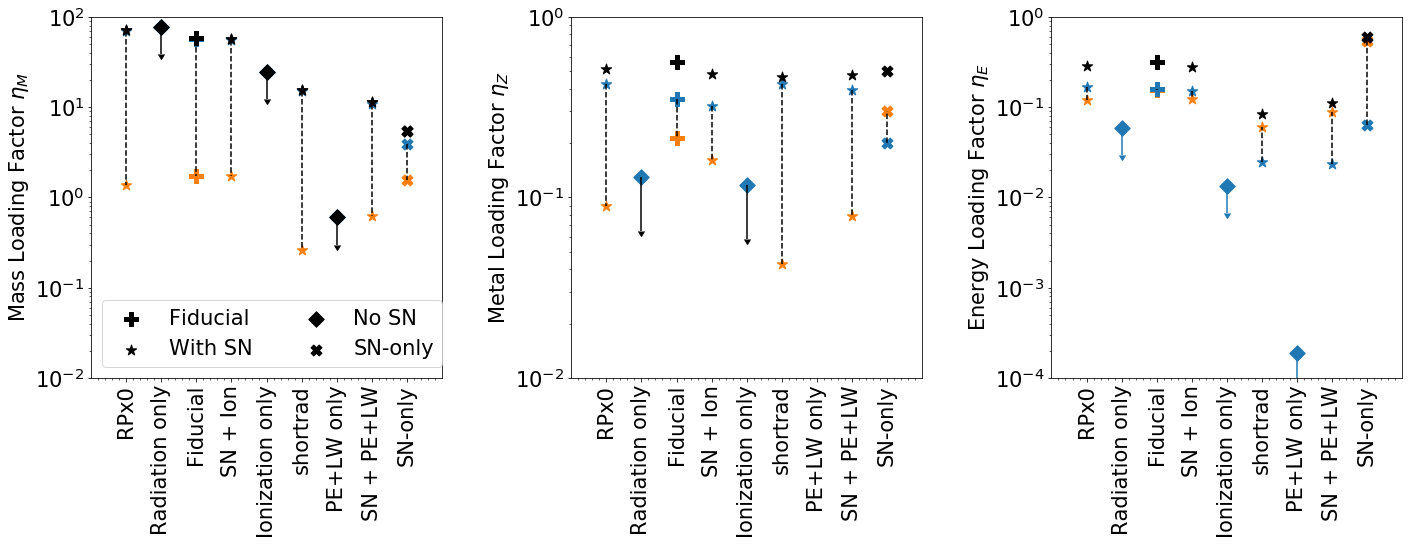

In [260]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 120
#arkers = {'sn_only' : 'o',
#           'otrad_ion-no-sn' : 's',
#           'otrad_no-ion-sn' : 'D',
#            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(1,3,sharex=True)
fig.set_size_inches(20,8)
#fig.subplots_adjust(hspace=0,wspace=0.25)

sfr_dict = {}
for run in base_comparison:
    if all_data[run].loading_table_values is None:
        continue
            
    sfr_dict[run] = all_data[run].loading_table_values['Sigma_sfr']
sfr_sort= np.argsort( list(sfr_dict.values()))
i = 0
for run in np.array(list(sfr_dict.keys()))[sfr_sort]:
    if all_data[run].loading_table_values is None:
        continue
        
    if run == 'fiducial':
        psize = 180
    else:
        psize = 120
        
    xval = i
    cval = sfr_dict[run]
    

    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, marker=markers[run])
    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, marker = markers[run])
    ax[0].scatter( xval,
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize,  marker = markers[run])   
    
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        temp = ax[0].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        temp[-1][0].set_linestyle('--')
    else:
        ax[0].scatter(xval,
                   all_data[run].loading_table_values['Eta_mass_cold'] + all_data[run].loading_table_values['Eta_mass_hot'],
                   color = total_color, s = psize, marker = markers[run]) 
        ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( xval,
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[1].scatter( xval,
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])   
     
    #print(run,all_data[run].loading_table_values['Sigma_sfr'],all_data[run].loading_table_values['Eta_metal_cold'])
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        temp = ax[1].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'black')
        temp[-1][0].set_linestyle('--')
    else:
        ax[1].scatter(xval,
                   all_data[run].loading_table_values['Eta_metal_cold'] + all_data[run].loading_table_values['Eta_metal_hot'],
                   color = total_color, s = psize, label = run, marker = markers[run]) 
        ax[1].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
############

    y = all_data[run].loading_table_values['Eta_E_hot']
    ax[2].scatter( xval,
                   y,
                   color = 'C1', s = psize, marker=markers[run])# markers[run] )

    x = all_data[run].loading_table_values['Sigma_sfr']
    y = all_data[run].loading_table_values['Eta_E_cold']
    xy = (x,y)
    ax[2].scatter( xval,y,
                   color = 'C0', s = psize, marker = markers[run])

    #xy = (x,y)
    #ax[(0,2)].annotate(labels[run], xy, xytext=xy, xycoords='data')    
    #ax[0].annotate(labels[run], xy, xytext=xy, xycoords='data')
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ xval]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
        
        temp = ax[2].errorbar(xval, yline[0], xerr=0, yerr=yline[0]*0.5, uplims=1, color = 'C0')
        temp[-1][0].set_linestyle('--')
                      
    else:

    
        ax[2].scatter(xval, all_data[run].loading_table_values['Eta_E_hot'] + all_data[run].loading_table_values['Eta_E_cold'],
                  color = total_color, s = psize,marker = markers[run])        
        ax[2].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    i = i + 1


# marker labels
ax[0].scatter(-1,-1,color='black',s=180, marker = 'P', label = 'Fiducial')
ax[0].scatter(-1,-1,color='black',s=psize, marker = '*', label = 'With SN')
ax[0].scatter(-1,-1,color='black',s=psize, marker = 'D', label = 'No SN')
ax[0].scatter(-1,-1,color='black',s=psize, marker = 'X', label = 'SN-only')


xticklabels = [labels[run] for run in np.array( list(sfr_dict.keys()))[sfr_sort]]

for a in ax:
    a.semilogy()
    a.set_xlim(-1,i)
    a.set_xticks(np.arange(0,i))
    a.set_xticklabels(xticklabels, rotation='vertical')
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[1].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[2].set_ylabel(r"Energy Loading Factor $\eta_E$")

#ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
#ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
#ax[(1,2)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

#ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")
#ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")
#ax[(1,2)].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")

#ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
#ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[0].set_ylim(1.0E-2,100.0)
ax[1].set_ylim(1.0E-2,1.0)
ax[2].set_ylim(1.0E-4,1.0)

ax[0].legend(loc='lower left',ncol=2)


plt.tight_layout()
fig.savefig("phys_comparison_bar_mass_metal_hot_cold_SFR.png")


In [380]:
plot_settings()

fs = 4

def plot_image_panel(time,axis):

    fig, ax = plt.subplots(3,3, sharex=True, sharey=True)
    fig.set_size_inches(fs*3,fs*3)
    fig.subplots_adjust(wspace=0,hspace=0)

    #
    # plot many panel phase diagram
    #


    runs = ['fiducial', 'sn_otrad_no-ion', 'sn_ion-no-otrad',
            'shortrad', 'sn_only', 'sn_otrad_ion_noRP',
            'otrad_ion-no-sn', 'otrad_no-ion-sn', 'ion_no-otrad-sn']

    image_type = 'proj'
    xlim = [-2.5,2.5]
    ylim = [2.5, 2.5]
    #phase_type = "nT_phase_outside_disk"


    axi,axj=0,0
    for i,run in enumerate(runs):
        axindex = (axi,axj)


        if axi == 2:
            ax[axindex].set_xlabel(r"x (pc)")
            ax[axindex].set_xticks([-1000,0,1000])

        if axj == 0:
            ax[axindex].set_ylabel(r"y (pc)")
        else:
            ax[axindex].set_yticks([])
            #ax[axindex].set_yticks([1,2,3,4,5,6,7])


        # iterate for now to work woth continue
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1
        xy = (0.025,0.025)
        ax[axindex].annotate( labels[run], xy=xy,xycoords='axes fraction')

        image_data = all_data[run].load_image(time, "('gas', 'number_density')",axis, "proj")

        if image_data is None:
            print("Missing data for run ", run)
            continue

        im = ax[axindex].imshow(image_data, cmap = 'viridis', norm = LogNorm())

                                     #vmin=np.log10(0.01), vmax = np.log10(6.0E4))

        #ax[axindex].annotate(xy,xytext=)
        #ax[axindex].semilogx()
        #ax[axindex].semilogy()
        #ax[axindex].set_xlim(-6,3)
        #ax[axindex].set_ylim(0,7)



        if axindex[1] == 2:
            divider = make_axes_locatable(ax[axindex])
            cax     = divider.append_axes("right", size="5%", pad=0.05)    


            c = fig.colorbar(im, cax=cax)
            c.set_label(r"n cm$^{-3}$")

        plt.minorticks_on()
    
    fig.savefig("proj_plot_n_" + axis + "_" + "%5.2f"%(time) + ".png")

    plt.close()
    return

plot_image_panel(125,'x')

-74